In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import xgboost as xgb
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.svm import SVC

In [2]:
train_data = pd.read_csv('/kaggle/input/crime-cast-forecasting-crime-categories/train.csv')
test_data = pd.read_csv("/kaggle/input/crime-cast-forecasting-crime-categories/test.csv")
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Location               20000 non-null  object 
 1   Cross_Street           3448 non-null   object 
 2   Latitude               20000 non-null  float64
 3   Longitude              20000 non-null  float64
 4   Date_Reported          20000 non-null  object 
 5   Date_Occurred          20000 non-null  object 
 6   Time_Occurred          20000 non-null  float64
 7   Area_ID                20000 non-null  float64
 8   Area_Name              20000 non-null  object 
 9   Reporting_District_no  20000 non-null  float64
 10  Part 1-2               20000 non-null  float64
 11  Modus_Operandi         17259 non-null  object 
 12  Victim_Age             20000 non-null  float64
 13  Victim_Sex             17376 non-null  object 
 14  Victim_Descent         17376 non-null  object 
 15  Pr

In [3]:
type(train_data)

pandas.core.frame.DataFrame

In [4]:
# print(train_data.info())
# # print(train_data.describe())
# # print(train_data.head())
# # train_data.columns
# # print(train_data.shape)
train_data.isnull().sum()
test_data.isnull().sum()

# train_data['Victim_Sex']

Location                    0
Cross_Street             4190
Latitude                    0
Longitude                   0
Date_Reported               0
Date_Occurred               0
Time_Occurred               0
Area_ID                     0
Area_Name                   0
Reporting_District_no       0
Part 1-2                    0
Modus_Operandi            684
Victim_Age                  0
Victim_Sex                643
Victim_Descent            643
Premise_Code                0
Premise_Description         1
Weapon_Used_Code         3153
Weapon_Description       3153
Status                      0
Status_Description          0
dtype: int64

In [5]:
# Impute missing values in 'Modus_Operandi' and 'Weapon_Description' with 'Unknown'
mo_imputer = SimpleImputer(strategy='constant', fill_value='Unknown')
train_data['Modus_Operandi'] = mo_imputer.fit_transform(train_data[['Modus_Operandi']]).ravel()
test_data['Modus_Operandi'] = mo_imputer.transform(test_data[['Modus_Operandi']]).ravel()

train_data['Weapon_Description'] = mo_imputer.fit_transform(train_data[['Weapon_Description']]).ravel()
test_data['Weapon_Description'] = mo_imputer.transform(test_data[['Weapon_Description']]).ravel()

# Impute missing values in 'Victim_Sex' and 'Victim_Descent' with 'Unknown'
sex_imputer = SimpleImputer(strategy='constant', fill_value='Unknown')
train_data['Victim_Sex'] = sex_imputer.fit_transform(train_data[['Victim_Sex']]).ravel()
test_data['Victim_Sex'] = sex_imputer.transform(test_data[['Victim_Sex']]).ravel()

train_data['Victim_Descent'] = sex_imputer.fit_transform(train_data[['Victim_Descent']]).ravel()
test_data['Victim_Descent'] = sex_imputer.transform(test_data[['Victim_Descent']]).ravel()

# Impute missing values in 'Premise_Description' with the most frequent value
premises_imputer = SimpleImputer(strategy='most_frequent')
train_data['Premise_Description'] = premises_imputer.fit_transform(train_data[['Premise_Description']]).ravel()
test_data['Premise_Description'] = premises_imputer.transform(test_data[['Premise_Description']]).ravel()

# Extract date and time features from 'Date_Occurred' and 'Time_Occurred'
train_data['Date_Occurred'] = pd.to_datetime(train_data['Date_Occurred'], errors='coerce')
test_data['Date_Occurred'] = pd.to_datetime(test_data['Date_Occurred'], errors='coerce')

train_data['Month'] = train_data['Date_Occurred'].dt.month
train_data['Day'] = train_data['Date_Occurred'].dt.day
train_data['Hour'] = train_data['Time_Occurred'].apply(lambda x: int(str(x).zfill(4)[:2]))

test_data['Month'] = test_data['Date_Occurred'].dt.month
test_data['Day'] = test_data['Date_Occurred'].dt.day
test_data['Hour'] = test_data['Time_Occurred'].apply(lambda x: int(str(x).zfill(4)[:2]))

# Drop columns with a high percentage of missing values
columns_to_drop = ['Cross_Street', 'Weapon_Used_Code', 'Date_Occurred']
train_data.drop(columns=columns_to_drop, inplace=True)
test_data.drop(columns=columns_to_drop, inplace=True)

# Define the features and target
X = train_data.drop(columns=['Crime_Category'])
y = train_data['Crime_Category']

# Split the data into training and validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Identify categorical and numerical columns
categorical_cols = [col for col in X_train.columns if X_train[col].dtype == 'object']
numerical_cols = [col for col in X_train.columns if X_train[col].dtype == 'float64']



# Standardize Latitude and Longitude
scaler = StandardScaler()
train_data[['Latitude', 'Longitude']] = scaler.fit_transform(train_data[['Latitude', 'Longitude']])
test_data[['Latitude', 'Longitude']] = scaler.transform(test_data[['Latitude', 'Longitude']])

/tmp/ipykernel_18/3928704231.py:23: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  train_data['Date_Occurred'] = pd.to_datetime(train_data['Date_Occurred'], errors='coerce')
/tmp/ipykernel_18/3928704231.py:24: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  test_data['Date_Occurred'] = pd.to_datetime(test_data['Date_Occurred'], errors='coerce')


In [6]:
print(train_data.isnull().sum())
print(test_data.isnull().sum())

Location                 0
Latitude                 0
Longitude                0
Date_Reported            0
Time_Occurred            0
Area_ID                  0
Area_Name                0
Reporting_District_no    0
Part 1-2                 0
Modus_Operandi           0
Victim_Age               0
Victim_Sex               0
Victim_Descent           0
Premise_Code             0
Premise_Description      0
Weapon_Description       0
Status                   0
Status_Description       0
Crime_Category           0
Month                    0
Day                      0
Hour                     0
dtype: int64
Location                 0
Latitude                 0
Longitude                0
Date_Reported            0
Time_Occurred            0
Area_ID                  0
Area_Name                0
Reporting_District_no    0
Part 1-2                 0
Modus_Operandi           0
Victim_Age               0
Victim_Sex               0
Victim_Descent           0
Premise_Code             0
Premise_Descrip

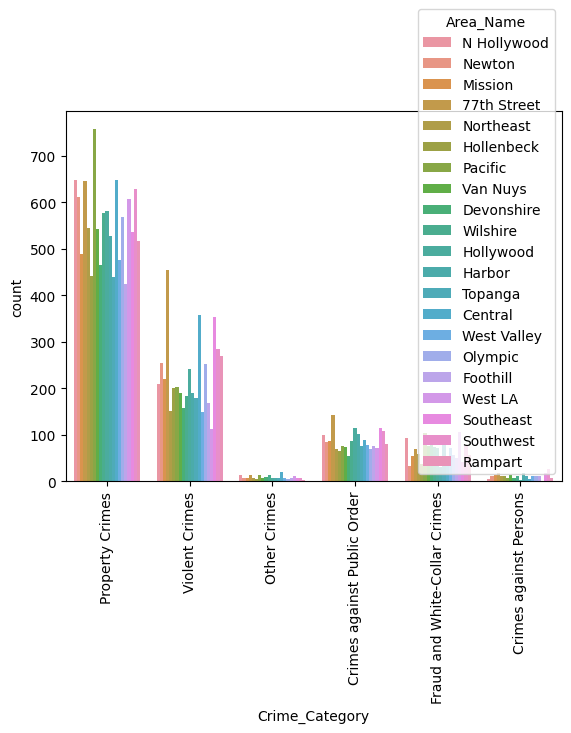

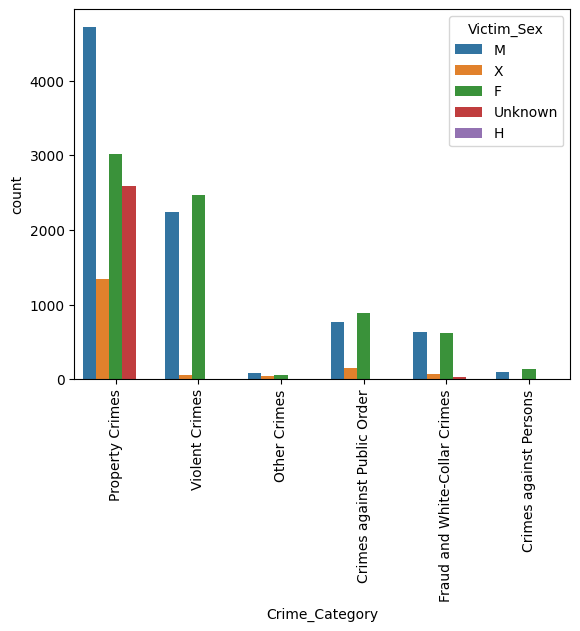

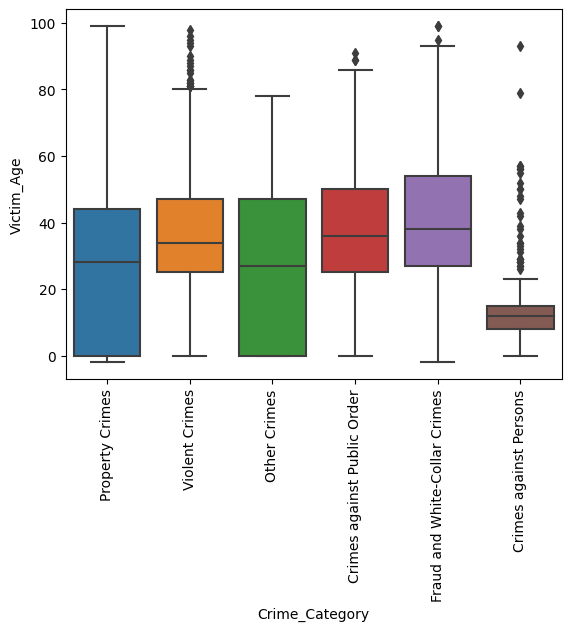

In [7]:

import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(data=train_data, x = 'Crime_Category', hue = 'Area_Name')
plt.xticks(rotation = 90)
plt.show()


sns.countplot(data=train_data, x='Crime_Category', hue='Victim_Sex')
plt.xticks(rotation=90)
plt.show()

sns.boxplot(data=train_data, x='Crime_Category', y='Victim_Age')
plt.xticks(rotation=90)
plt.show()

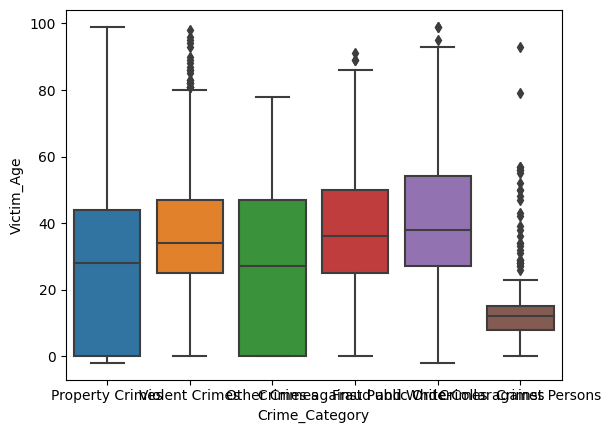

In [8]:
# Box plot for a numerical feature vs. target variable
sns.boxplot(x='Crime_Category', y='Victim_Age', data=train_data)
plt.show()


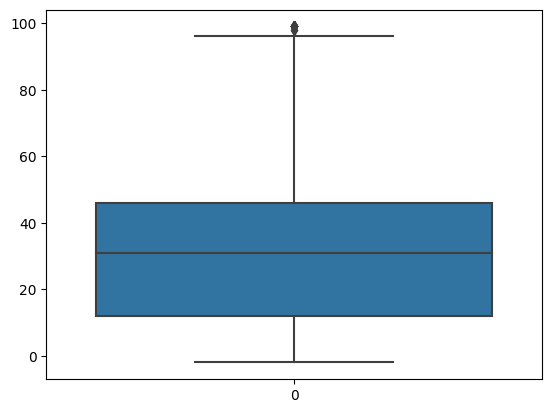

In [9]:
import seaborn as sns

# Box plot for numerical features
sns.boxplot(train_data['Victim_Age'])
plt.show()



In [10]:
# Split the data into features and target
X = train_data.drop(columns=['Crime_Category'])
y = train_data['Crime_Category']

In [11]:
# Split the data into training and validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [12]:
# Identify categorical and numerical columns
categorical_cols = [col for col in X_train.columns if X_train[col].dtype == 'object']
numerical_cols = [col for col in X_train.columns if X_train[col].dtype == 'float64']


In [13]:
# Define preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
            ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False))
        ]), categorical_cols),
        ('num', StandardScaler(), numerical_cols)
    ],
    remainder='passthrough'
)

In [14]:
# Fit and transform the training data
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)
test_data_transformed = preprocessor.transform(test_data)

# Convert to DataFrame for easier handling
X_train_transformed = pd.DataFrame(X_train_transformed, columns=preprocessor.get_feature_names_out())
X_test_transformed = pd.DataFrame(X_test_transformed, columns=preprocessor.get_feature_names_out())


/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [15]:
# SVM model
svm_model = SVC(kernel='linear', C=1.0, random_state=42)

In [16]:
# Training the model
svm_model.fit(X_train_transformed, y_train)

#Predictions on the validation set
y_pred = svm_model.predict(X_test_transformed)

In [17]:
# Predictions on the test data
test_predictions = svm_model.predict(test_data_transformed)


/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


In [18]:
print("SVM Accuracy:", accuracy_score(y_test, y_pred))
print("SVM Classification Report:\n", classification_report(y_test, y_pred))

SVM Accuracy: 0.876
SVM Classification Report:
                                precision    recall  f1-score   support

       Crimes against Persons       0.37      0.22      0.27        32
  Crimes against Public Order       0.69      0.67      0.68       374
Fraud and White-Collar Crimes       0.80      0.85      0.82       267
                 Other Crimes       0.13      0.06      0.08        35
              Property Crimes       0.95      0.93      0.94      2303
               Violent Crimes       0.82      0.89      0.86       989

                     accuracy                           0.88      4000
                    macro avg       0.63      0.60      0.61      4000
                 weighted avg       0.87      0.88      0.87      4000



In [19]:
# # from sklearn.feature_selection import SelectKBest, chi2

# # # Example: Feature selection
# # X = train_data.drop(columns=['Crime_Category'])
# # y = train_data['Crime_Category']
# # selector = SelectKBest(chi2, k=10)
# # X_new = selector.fit_transform(X, y)

# print(train_data.shape)
# print(train_data.columns)
# test_data.shape
# print(test_data.columns)

In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score,confusion_matrix

# Example: Train Random Forest model
model = RandomForestClassifier()
model.fit(X_train_transformed, y_train)

# Predict and evaluate
# y_pred = model.predict(X_test_transformed)
# print(accuracy_score(y_test, y_pred))
# print(classification_report(y_test, y_pred))


RandomForestClassifier()

In [21]:
RFC_model = model

In [22]:
# Predict and evaluate
y_pred = model.predict(X_test_transformed)
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

0.85225
                               precision    recall  f1-score   support

       Crimes against Persons       0.00      0.00      0.00        32
  Crimes against Public Order       0.83      0.45      0.58       374
Fraud and White-Collar Crimes       0.79      0.66      0.72       267
                 Other Crimes       1.00      0.03      0.06        35
              Property Crimes       0.87      0.94      0.91      2303
               Violent Crimes       0.82      0.90      0.86       989

                     accuracy                           0.85      4000
                    macro avg       0.72      0.50      0.52      4000
                 weighted avg       0.84      0.85      0.84      4000



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [23]:
from sklearn.neighbors import KNeighborsClassifier

# Initialize the KNN classifier with the number of neighbors (k)
knn = KNeighborsClassifier(n_neighbors=10)  # You can tune the n_neighbors parameter

# Train the model
knn.fit(X_train_transformed, y_train)


KNeighborsClassifier(n_neighbors=10)

In [24]:
y_pred = knn.predict(X_test_transformed)
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

0.70125
                               precision    recall  f1-score   support

       Crimes against Persons       0.00      0.00      0.00        32
  Crimes against Public Order       0.34      0.11      0.17       374
Fraud and White-Collar Crimes       0.45      0.44      0.44       267
                 Other Crimes       0.00      0.00      0.00        35
              Property Crimes       0.73      0.94      0.83      2303
               Violent Crimes       0.74      0.47      0.58       989

                     accuracy                           0.70      4000
                    macro avg       0.38      0.33      0.34      4000
                 weighted avg       0.67      0.70      0.66      4000



In [25]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {'n_neighbors': range(1, 20)}

# Initialize the GridSearchCV object
grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5)

# Fit the model to the data
grid_search.fit(X_train_transformed, y_train)

# Best parameters found
print("Best Parameters:", grid_search.best_params_)

# Use the best model
best_knn = grid_search.best_estimator_

# Predict and evaluate 
y_pred_best = best_knn.predict(X_test_transformed)
print("\nBest KNN Model Accuracy:", accuracy_score(y_test, y_pred_best))


Best Parameters: {'n_neighbors': 9}

Best KNN Model Accuracy: 0.704


In [26]:
from sklearn.preprocessing import LabelEncoder
# Encode the target labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

In [27]:
# import xgboost as xgb
# # Training with XGBoost
# xgb_model = xgb.XGBClassifier(n_estimators=100, max_depth=6, learning_rate=0.1, subsample=0.8, colsample_bytree=0.8, random_state=42)
# xgb_model.fit(X_train_transformed, y_train_encoded)
# y_pred_xgb = xgb_model.predict(X_test_transformed)
# print("XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))
# print("XGBoost Classification Report:\n", classification_report(y_test, y_pred_xgb))


In [28]:
# # Evaluate the model's performance
# print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
# print("\nClassification Report:\n", classification_report(y_test, y_pred))
# print("\nAccuracy Score:", accuracy_score(y_test, y_pred))


In [29]:
# from sklearn.model_selection import cross_val_score, GridSearchCV
# from sklearn.metrics import make_scorer, accuracy_score, f1_score

# # Define models
# models = {
#     'SVM': SVC(kernel='linear', random_state=42),
#     'XGBoost': xgb.XGBClassifier(random_state=42),
#     'LightGBM': lgb.LGBMClassifier(random_state=42)
# }
# q
# # Define hyperparameters for each model
# param_grids = {
#     'SVM': {
#         'C': [0.1, 1, 10],
#         'kernel': ['linear', 'rbf']
#     },
#     'XGBoost': {
#         'n_estimators': [50, 100, 200],
#         'max_depth': [3, 6, 9],
#         'learning_rate': [0.01, 0.1, 0.2]
#     },
#     'LightGBM': {
#         'n_estimators': [50, 100, 200],
#         'num_leaves': [31, 50, 100],
#         'learning_rate': [0.01, 0.1, 0.2]
#     }
# }

# # Results storage
# best_models = {}
# best_scores = {}
# scoring = make_scorer(accuracy_score)  # or use 'f1_macro' for F1 score

# # Iterate over models and perform Grid Search
# for model_name, model in models.items():
#     print(f"Training {model_name}...")
#     grid_search = GridSearchCV(model, param_grids[model_name], cv=5, scoring=scoring, n_jobs=-1)
#     grid_search.fit(X_train_transformed, y_train)
#     best_models[model_name] = grid_search.best_estimator_
#     best_scores[model_name] = grid_search.best_score_
#     print(f"Best {model_name} score: {grid_search.best_score_} with params: {grid_search.best_params_}")

# # Compare the models
# best_model_name = max(best_scores, key=best_scores.get)
# best_model = best_models[best_model_name]
# print(f"Best model: {best_model_name} with score: {best_scores[best_model_name]}")

# # Final evaluation on the validation set
# y_pred_best = best_model.predict(X_test_transformed)
# print(f"Final evaluation with the best model ({best_model_name}):")
# print("Accuracy:", accuracy_score(y_test, y_pred_best))
# print("Classification Report:\n", classification_report(y_test, y_pred_best))


In [30]:
def make_submission_file(model):
    y_test_pred = model.predict(test_data_transformed)
     
    output = pd.DataFrame(columns=["ID","Crime_Category"])
    output["ID"] = test_data.index+1
    output['Crime_Category'] =  pd.Series(y_test_pred)
    output['Crime_Category'] = output['Crime_Category']
 
    print(output.head())
    output.to_csv("/kaggle/working/submission.csv", index=False)

In [31]:

# test_data_transformed = preprocessor.transform(test_data)
make_submission_file(svm_model)

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


   ID               Crime_Category
0   1               Violent Crimes
1   2              Property Crimes
2   3  Crimes against Public Order
3   4              Property Crimes
4   5  Crimes against Public Order
